In [1]:
import tensorboard

In [2]:
import os

import matplotlib.pyplot as plt
import tensorflow
from keras.callbacks import TensorBoard
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

import src.data.Dataset as dt

In [3]:
required_paths = ["/ai4eutils", "/CameraTraps", "/yolov5"]
python_path = os.environ.get("PYTHONPATH", "")
root_path = os.getcwd()

for path in required_paths:
    if not any(p.endswith(path) for p in python_path.split(":")):
        python_path += f":{root_path}/data/external{path}"

os.environ["PYTHONPATH"] = python_path

!echo "PYTHONPATH: $PYTHONPATH"

PYTHONPATH: :/Users/carlos/WORKSPACE/MegaClassifier/data/external/ai4eutils:/Users/carlos/WORKSPACE/MegaClassifier/data/external/CameraTraps:/Users/carlos/WORKSPACE/MegaClassifier/data/external/yolov5


In [4]:
IMAGES_DATASET_PATH = os.path.abspath("./data/raw/emptyNonEmptyDataset_ETL")

TRAIN_SAMPLES_CSV = os.path.abspath(
    "./data/raw/emptyNonEmptyDataset_ETL/28570Train.csv"
)
VALIDATION_SAMPLES_CSV = os.path.abspath(
    "./data/raw/emptyNonEmptyDataset_ETL/28570Validation.csv"
)
TEST_SAMPLES_CSV = os.path.abspath("./data/raw/emptyNonEmptyDataset_ETL/28570Test.csv")

print(f"IMAGES_DATASET_PATH:    {IMAGES_DATASET_PATH}")
print(f"TRAIN_SAMPLES_CSV:      {TRAIN_SAMPLES_CSV}")
print(f"VALIDATION_SAMPLES_CSV: {VALIDATION_SAMPLES_CSV}")
print(f"TEST_SAMPLES_CSV:       {TEST_SAMPLES_CSV}")

IMAGES_DATASET_PATH:    /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL
TRAIN_SAMPLES_CSV:      /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Train.csv
VALIDATION_SAMPLES_CSV: /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Validation.csv
TEST_SAMPLES_CSV:       /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Test.csv


In [5]:
train_dataframe = dt.load_from_csv(TRAIN_SAMPLES_CSV)
validation_dataframe = dt.load_from_csv(VALIDATION_SAMPLES_CSV)
test_dataframe = dt.load_from_csv(TEST_SAMPLES_CSV)

The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Train.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Validation.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Test.csv has been successfully opened.


In [6]:
train_dataframe["file_name"] = train_dataframe["file_name"].apply(
    lambda x: os.path.join(IMAGES_DATASET_PATH, x)
)
train_dataframe["binary_label"] = train_dataframe["binary_label"].astype(str)

validation_dataframe["file_name"] = validation_dataframe["file_name"].apply(
    lambda x: os.path.join(IMAGES_DATASET_PATH, x)
)
validation_dataframe["binary_label"] = validation_dataframe["binary_label"].astype(str)

test_dataframe["file_name"] = test_dataframe["file_name"].apply(
    lambda x: os.path.join(IMAGES_DATASET_PATH, x)
)
test_dataframe["binary_label"] = test_dataframe["binary_label"].astype(str)

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
VERSION = 1.0

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
normal_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
normal_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_images = train_datagen.flow_from_dataframe(
    dataframe=train_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=42,
)

validation_images = normal_datagen.flow_from_dataframe(
    dataframe=validation_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=42,
)

test_images = normal_datagen.flow_from_dataframe(
    dataframe=test_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

Found 19998 validated image filenames belonging to 2 classes.
Found 4284 validated image filenames belonging to 2 classes.
Found 4288 validated image filenames belonging to 2 classes.


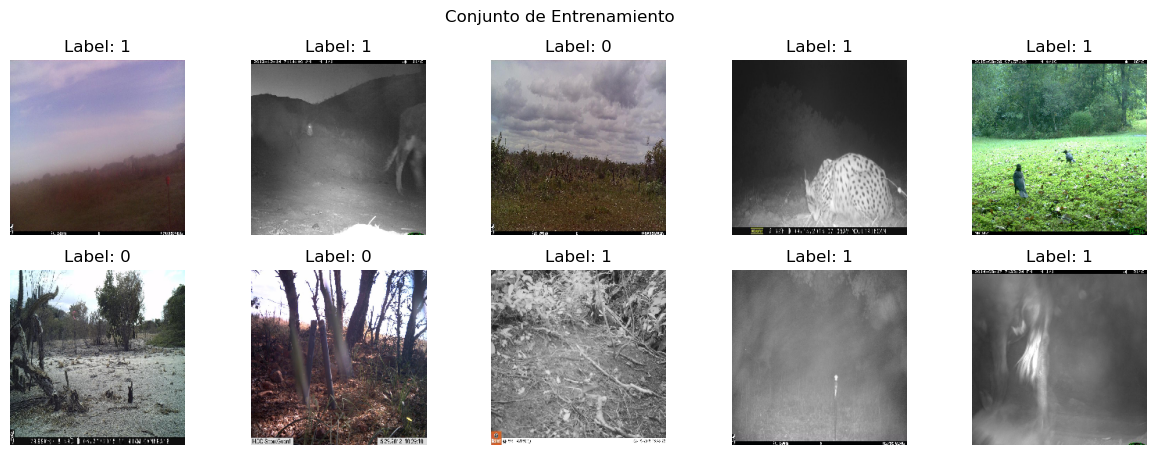

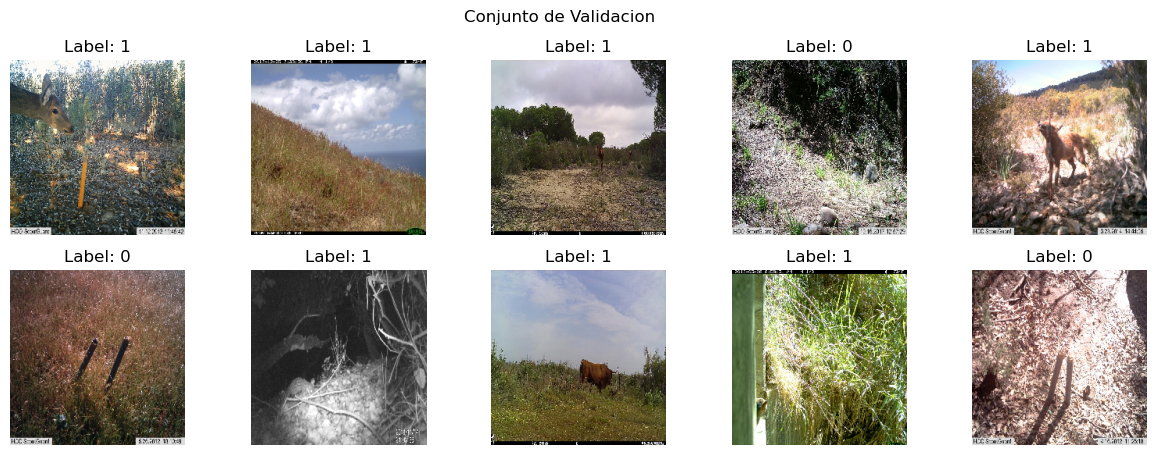

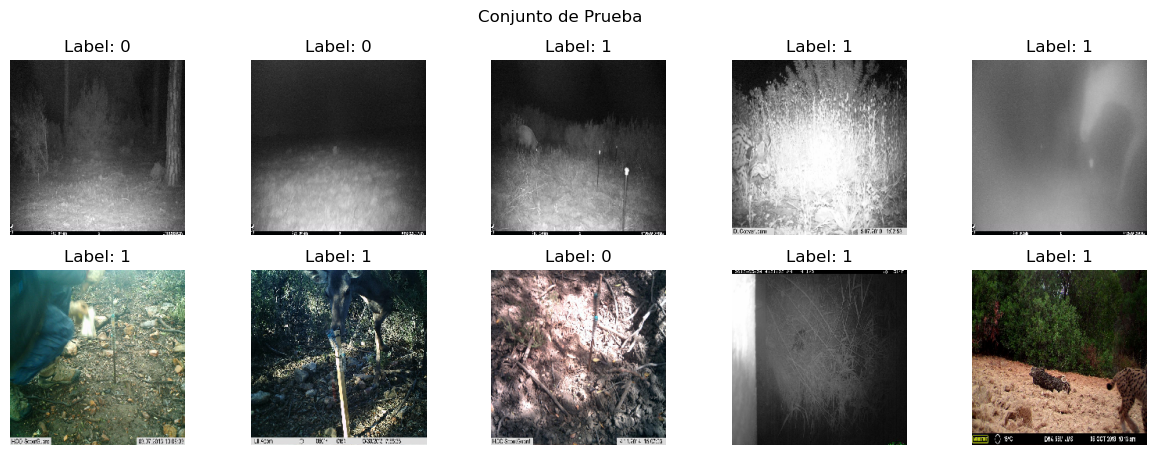

In [8]:
def show_random_images_from_generator(generator, title):
    images, labels = next(generator)
    # Asegúrate de que las imágenes estén en el rango [0, 1] para visualizarlas correctamente
    images = (
        images + 1
    ) * 127.5  # Si las imágenes están en el rango [-1, 1], esto las lleva a [0, 255]
    images = np.clip(images, 0, 255)  # Asegúrate de que no haya valores fuera de rango

    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(
            images[i].astype("uint8")
        )  # Convierte a enteros de 8 bits para la visualización
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


show_random_images_from_generator(train_images, "Conjunto de Entrenamiento")
show_random_images_from_generator(validation_images, "Conjunto de Validacion")
show_random_images_from_generator(test_images, "Conjunto de Prueba")

In [9]:
base_model = tensorflow.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False

# Construir el modelo básico
model = tensorflow.keras.models.Sequential(
    [
        base_model,
        tensorflow.keras.layers.GlobalAveragePooling2D(),
        tensorflow.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall(), AUC()],
)

model.summary()

2024-12-02 20:14:29.959606: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-02 20:14:29.959638: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-02 20:14:29.959647: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-02 20:14:29.959680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-02 20:14:29.959695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [10]:
history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=EPOCHS,
    callbacks=[TensorBoard(log_dir=f"./logs/MobileNetV2/v.{VERSION}")],
)

Epoch 1/10


2024-12-02 20:14:32.233788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.2975 - accuracy: 0.8680 - precision: 0.8959 - recall: 0.9058 - auc: 0.9396

2024-12-02 20:16:30.981461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 146s 231ms/step - loss: 0.2975 - accuracy: 0.8680 - precision: 0.8959 - recall: 0.9058 - auc: 0.9396 - val_loss: 0.2434 - val_accuracy: 0.8968 - val_precision: 0.9365 - val_recall: 0.9055 - val_auc: 0.9618
Epoch 2/10
625/625 [==============================] - 143s 229ms/step - loss: 0.2359 - accuracy: 0.8973 - precision: 0.9226 - recall: 0.9221 - auc: 0.9626 - val_loss: 0.2249 - val_accuracy: 0.9078 - val_precision: 0.9141 - val_recall: 0.9499 - val_auc: 0.9673
Epoch 3/10
625/625 [==============================] - 143s 228ms/step - loss: 0.2184 - accuracy: 0.9029 - precision: 0.9255 - recall: 0.9279 - auc: 0.9680 - val_loss: 0.2142 - val_accuracy: 0.9094 - val_precision: 0.9422 - val_recall: 0.9196 - val_auc: 0.9698
Epoch 4/10
625/625 [==============================] - 142s 227ms/step - loss: 0.2071 - accuracy: 0.9100 - precision: 0.9313 - recall: 0.9327 - auc: 0.9713 - val_loss: 0.2049 - val_accuracy: 0.9150 - val_precision: 0.9285 - val_reca

In [ ]:
model.save(f"./models/MobileNetV2/MobileNetV2_v.{VERSION}")

INFO:tensorflow:Assets written to: ./models/MobileNetV2_v.1.0/assets


INFO:tensorflow:Assets written to: ./models/MobileNetV2_v.1.0/assets


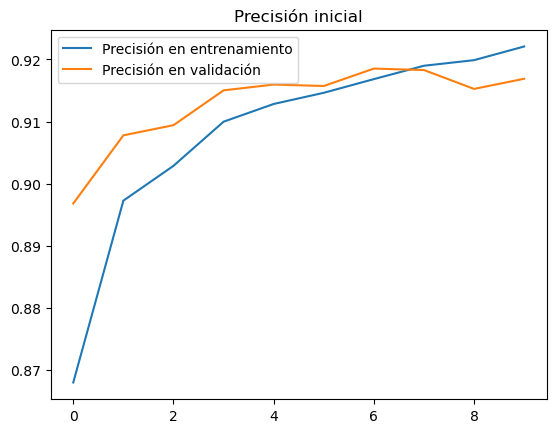

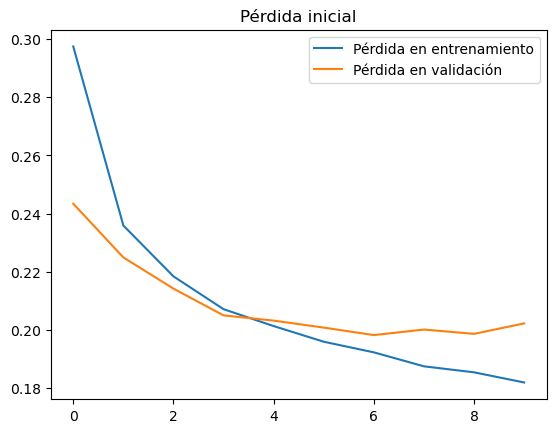

In [12]:
plt.plot(history.history["accuracy"], label="Precisión en entrenamiento")
plt.plot(history.history["val_accuracy"], label="Precisión en validación")
plt.title("Precisión inicial")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Pérdida en entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida en validación")
plt.title("Pérdida inicial")
plt.legend()
plt.show()